# Relatório de Análise Exploratória – Alfabetização de Adultos no Brasil (Censo 2022 & INEP 2022)

## **1. Introdução**

A alfabetização é fundamental para o entendimento do desenvolvimento humano e social. Compreender como ela se distribui entre diferentes grupos populacionais ajuda a identificar desigualdades, orientar políticas públicas e revelar padrões regionais. Nesta análise exploratória, investigamos a alfabetização de adultos no Brasil, com foco nas diferenças entre mulheres e homens.

A pergunta central que guia esta análiseé:

**Quantas mulheres autodeclararam que são alfabetizadas no Brasil em comparação aos homens?**

Para responder a essa questão, utilizei:

* **Censo Demográfico 2022 (IBGE)** – para quantificar homens e mulheres adultos alfabetizados por município e por UF.
* **Censo Escolar 2022 (INEP)** – para analisar matrículas associadas ao processo de alfabetização (anos iniciais do fundamental e EJA fundamental), também por sexo e UF.
* **SIDRA 2010 (IBGE)** – apenas como referência histórica do total de alfabetizados, por não ter o recorte por sexo.

O objetivo final é entender se há desigualdades de gênero, como essas diferenças variam entre estados e municípios, e como se relacionam com o fluxo educacional captado pelo INEP.

## **2. Fontes de Dados**

Para este estudo foram usados os seguintes dados extraídos no projeto:
  > https://github.com/patriciacarbri/etl-censo-bigquery-mulheres-brasil

### **2.1. Censo 2022 (Censo Demográfico – IBGE)**

* Nível de agregação: município
* População : padrão **autodeclarativa** do Censo
* Alfabetização definida como: **resposta “Sim, sabe ler e escrever”**
* Variáveis relevantes:

  * `id_municipio`, `nome_municipio`, `sigla_uf`
  * `populacao_homens`
  * `populacao_mulheres`
  * `populacao_total`


---

### **2.2. INEP 2022 (Censo Escolar)**

Usado para examinar matrículas em níveis associados ao processo de alfabetização:

* **QT_MAT_FUND_AI** – Matrículas nos anos iniciais do ensino fundamental
* **QT_MAT_EJA_FUND** – Matrículas da EJA no nível fundamental
* Matrículas por sexo:

  * `QT_MAT_BAS_FEM`
  * `QT_MAT_BAS_MASC`
* Variáveis geográficas:

  * `id_municipio`, `SG_UF`, `NO_UF`

Esses dados permitem observar se o padrão da alfabetização aparece também nas matrículas escolares.

---

### **2.3. SIDRA 2010**

Usado apenas para comparação histórica do total de alfabetizados (sem distinção por sexo).

---

## **3. Metodologia**

### **Critérios adotados**

* População analisada: **autodeclarativa**
* União das bases Censo–INEP: feita via **id_municipio**
* Nenhum filtro adicional (como escolaridade mínima) foi aplicado, para aderir à métrica oficial do IBGE.

### **Indicadores calculados**

* Taxa de alfabetização feminina por UF
* Taxa de alfabetização masculina por UF
* Gap de gênero: `taxa_mulheres − taxa_homens`
* Comparação entre alfabetização (Censo) e matrículas associadas à alfabetização (INEP)
* Análises detalhadas por município

---

In [27]:
# 1. Bibliotecas necessárias
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import stats

In [2]:
# 2. Configurações de diretórios e caminhos
"""
Conforme o informado, os dados aqui usados são de uma camada "confiável" (trusted), extraído por outro projeto que criou 
uma pipeline de extração e tratamento dos dados. Disponível em:
  > https://github.com/patriciacarbri/etl-censo-bigquery-mulheres-brasil.

"""
PATH_BQ = "data/censo_2022_trusted.parquet"
PATH_INEP = "data/inep_2022_trusted.parquet"
PATH_SIDRA = "data/sidra_2010_trusted.parquet"
OUT_DIR = "data/analysis_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [3]:
# 3. Carregamento dos dados
print('Carregando arquivos...')

df_censo = pd.read_parquet(PATH_BQ)
df_inep = pd.read_parquet(PATH_INEP)
df_sidra = pd.read_parquet(PATH_SIDRA)

print('Arquivos carregados:')
print('Censo (df_censo):', df_censo.shape)
print('INEP (df_inep):', df_inep.shape)
print('SIDRA 2010 (df_sidra):', df_sidra.shape)

Carregando arquivos...
Arquivos carregados:
Censo (df_censo): (779800, 8)
INEP (df_inep): (178346, 32)
SIDRA 2010 (df_sidra): (5565, 5)


In [4]:
# Apresentação da colunas dos dados extraídos:

print('\nColunas principais do Censo (bq):')
print(df_censo.columns.tolist())


print('\nColunas principais do INEP (df_inep):')
print(df_inep.columns.tolist()[:50])


print('\nColunas principais do SIDRA:')
print(df_sidra.columns.tolist()[:50])


Colunas principais do Censo (bq):
['id_municipio', 'nome_municipio', 'sigla_uf', 'sexo', 'cor_raca', 'grupo_idade', 'alfabetizacao', 'populacao']

Colunas principais do INEP (df_inep):
['NU_ANO_CENSO', 'NO_REGIAO', 'CO_REGIAO', 'NO_UF', 'SG_UF', 'CO_UF', 'NO_MUNICIPIO', 'id_municipio', 'QT_MAT_BAS', 'QT_MAT_INF', 'QT_MAT_INF_CRE', 'QT_MAT_INF_PRE', 'QT_MAT_FUND', 'QT_MAT_FUND_AI', 'QT_MAT_FUND_AF', 'QT_MAT_MED', 'QT_MAT_PROF', 'QT_MAT_PROF_TEC', 'QT_MAT_EJA', 'QT_MAT_EJA_FUND', 'QT_MAT_EJA_MED', 'QT_MAT_ESP', 'QT_MAT_ESP_CC', 'QT_MAT_ESP_CE', 'QT_MAT_BAS_FEM', 'QT_MAT_BAS_MASC', 'QT_MAT_BAS_ND', 'QT_MAT_BAS_BRANCA', 'QT_MAT_BAS_PRETA', 'QT_MAT_BAS_PARDA', 'QT_MAT_BAS_AMARELA', 'QT_MAT_BAS_INDIGENA']

Colunas principais do SIDRA:
['id_municipio', 'municipio', 'ano', 'sexo', 'valor']


Os dados extraídos do Censo possuem dados completos por sexo, grupo de idade, cor / raça e a declaração.
Os dados do Inep possuem uma granularidade maior mais centrada na quantidade de matrículas. Como este estudo está centrado em 
dados sobre alfabetização, serão usadas estas colunas.
Quanto ao SIDRA:
> É observado que no dataframe do SIDRA a coluna referente ao "sexo" está totalmente preenchida com o valor "Total", o que indica que os dados não estão segmentados por gênero.

In [13]:
df_sidra.head()

,id_municipio,municipio,ano,sexo,valor
0,1100015,Alta Floresta D'Oeste - RO,2010,Total,89.3
1,1100023,Ariquemes - RO,2010,Total,92.8
2,1100031,Cabixi - RO,2010,Total,87.8
3,1100049,Cacoal - RO,2010,Total,92.5
4,1100056,Cerejeiras - RO,2010,Total,90.7


Padronização mínima dos dados

> Como os dados já estão em formato "trusted" neste notebook serão aplicadas somente padronizações mínimas necessárias para a análise.

In [5]:
# Nomes de colunas padronizados:

# Padronização de nomes de colunas do Inep
df_inep = df_inep.rename(columns={
    'sg_uf': 'sigla_uf',
    'NO_MUNICIPIO': 'nome_municipio'})

# Garantir id_municipio como string 
for d in (df_censo, df_inep, df_sidra):
    if 'id_municipio' in d.columns:
        d['id_municipio'] = d['id_municipio'].astype(str)


### **CAPÍTULO 1 — Panorama geral da alfabetização feminina no Brasil**

Perguntas que você definiu:

1. **Qual é a distribuição da alfabetização feminina no Brasil em 2022?**
2. **Como a alfabetização feminina varia entre UFs ?**
3. **Quais capitais concentram os maiores e menores índices de alfabetização entre mulheres?**
 

**Objetivo do capítulo:**
Criar o retrato inicial. Gráficos + mapas.

In [12]:
**Como é distribuída a população feminina alfabetizada por raça dentro dos municípios e capitais?**

SyntaxError: invalid syntax (2937748808.py, line 1)

In [ ]:
# 1) Dicionário de capitais (inclui DF)
capitais = {
    "Rio Branco": "AC", "Maceió": "AL", "Macapá": "AP", "Manaus": "AM",
    "Salvador": "BA", "Fortaleza": "CE", "Brasília": "DF", "Vitória": "ES",
    "Goiânia": "GO", "São Luís": "MA", "Cuiabá": "MT", "Campo Grande": "MS",
    "Belo Horizonte": "MG", "Belém": "PA", "João Pessoa": "PB", "Curitiba": "PR",
    "Recife": "PE", "Teresina": "PI", "Rio de Janeiro": "RJ", "Natal": "RN",
    "Porto Alegre": "RS", "Porto Velho": "RO", "Boa Vista": "RR", "Florianópolis": "SC",
    "São Paulo": "SP", "Aracaju": "SE", "Palmas": "TO"
}

In [ ]:
df_censo.head()

,id_municipio,nome_municipio,sigla_uf,sexo,cor_raca,grupo_idade,alfabetizacao,populacao
0,1100015,Alta Floresta D'Oeste,RO,Homens,Amarela,15 a 19 anos,Alfabetizadas,0
1,1100015,Alta Floresta D'Oeste,RO,Homens,Amarela,15 a 19 anos,Não alfabetizadas,0
2,1100015,Alta Floresta D'Oeste,RO,Homens,Amarela,20 a 24 anos,Alfabetizadas,2
3,1100015,Alta Floresta D'Oeste,RO,Homens,Amarela,20 a 24 anos,Não alfabetizadas,0
4,1100015,Alta Floresta D'Oeste,RO,Homens,Amarela,25 a 34 anos,Alfabetizadas,5


In [ ]:
# 2) Filtrar capitais no df_censo
df_censoCapitais = df_censo[
    (df_censo['nome_municipio'].isin(capitais.keys()))
].copy()


In [ ]:
# garantir colunas mínimas
required = ['id_municipio', 'nome_municipio', 'sigla_uf', 'sexo', 'populacao']
for c in required:
    if c not in df_censo.columns:
        df_censo[c] = None

# normalizar sexo (tolerante a variações)
sexo_norm = (
    df_censo['sexo']
    .astype(str)
    .str.strip()
    .str.lower()
    .fillna('')
    .map(lambda s: 'Homens' if 'hom' in s else ('Mulheres' if 'mul' in s else s))
)
df_censo['sexo'] = sexo_norm

# garantir populacao numérica
df_censo['populacao'] = pd.to_numeric(df_censo['populacao'], errors='coerce').fillna(0).astype(int)

# agregar: somar populacao por id_municipio, nome_municipio, sigla_uf e sexo
agg = (
    df_censo
    .groupby(['id_municipio', 'nome_municipio', 'sigla_uf', 'sexo'], dropna=False)['populacao']
    .sum()
    .reset_index()
)

# pivotar para ter colunas por sexo
pivot = (
    agg
    .pivot_table(
        index=['id_municipio', 'nome_municipio', 'sigla_uf'],
        columns='sexo',
        values='populacao',
        aggfunc='sum',
        fill_value=0
    )
    .reset_index()
)

# renomear/garantir colunas esperadas
pivot = pivot.rename(columns={
    'Homens': 'populacao_homens',
    'Mulheres': 'populacao_mulheres'
})

# garantir existência das colunas (se faltou algum sexo)
if 'populacao_homens' not in pivot.columns:
    pivot['populacao_homens'] = 0
if 'populacao_mulheres' not in pivot.columns:
    pivot['populacao_mulheres'] = 0

pivot['populacao_homens'] = pivot['populacao_homens'].astype(int)
pivot['populacao_mulheres'] = pivot['populacao_mulheres'].astype(int)

# diferença mulheres - homens
pivot['dif_mulheres_homens'] = pivot['populacao_mulheres'] - pivot['populacao_homens']

# resultado final
df_censoCapitais = pivot[['id_municipio', 'nome_municipio', 'sigla_uf',
                          'populacao_homens', 'populacao_mulheres', 'dif_mulheres_homens']].copy()


In [ ]:
# 3) Ranking (diferença absoluta mulheres - homens) e tabela resultante
df_censoCapitais['dif_mulheres_homens'] = df_censoCapitais['populacao_mulheres'] - df_censoCapitais['populacao_homens']
df_ranking = df_censoCapitais.sort_values('dif_mulheres_homens', ascending=False).reset_index(drop=True)


In [ ]:
df_ranking[['nome_municipio',  'sigla_uf', 'populacao_homens', 'populacao_mulheres', 'dif_mulheres_homens']].head(10)

sexo,nome_municipio,sigla_uf,populacao_homens,populacao_mulheres,dif_mulheres_homens
0,São Paulo,SP,4391453,5106518,715065
1,Rio de Janeiro,RJ,2357034,2821689,464655
2,Salvador,BA,896709,1115241,218532
3,Fortaleza,CE,897973,1081420,183447
4,Belo Horizonte,MG,892949,1063235,170286
5,Brasília,DF,1070978,1212089,141111
6,Recife,PE,548938,676213,127275
7,Porto Alegre,RS,504434,614812,110378
8,Curitiba,PR,690860,795390,104530
9,Belém,PA,490513,577698,87185


In [ ]:
df_ranking[['nome_municipio', 'sigla_uf', 'populacao_homens', 'populacao_mulheres', 'dif_mulheres_homens']].tail(10)

sexo,nome_municipio,sigla_uf,populacao_homens,populacao_mulheres,dif_mulheres_homens
5560,Guareí,SP,7832,4861,-2971
5561,Moju,PA,31981,28811,-3170
5562,Tremembé,SP,22796,19513,-3283
5563,Serra Azul,SP,7271,3675,-3596
5564,Mirandópolis,SP,13931,10212,-3719
5565,São Félix do Xingu,PA,26242,22351,-3891
5566,Lavínia,SP,6768,2128,-4640
5567,Pacaembu,SP,9007,4282,-4725
5568,Santa Isabel do Pará,PA,31650,26035,-5615
5569,Itaitinga,CE,29871,22407,-7464


##  **Qual é a distribuição da alfabetização feminina no Brasil em 2022?**

In [6]:
# Filtrar mulheres e homens
df_mulheres = df_censo[df_censo['sexo'] == 'Mulheres'].copy()
df_homens = df_censo[df_censo['sexo'] == 'Homens'].copy()

# Garantir tipo numérico
df_mulheres['populacao'] = pd.to_numeric(df_mulheres['populacao'], errors='coerce').fillna(0)
df_homens['populacao'] = pd.to_numeric(df_homens['populacao'], errors='coerce').fillna(0)

# Distribuição de alfabetização - MULHERES
dist_alf_feminina = (
    df_mulheres.groupby('alfabetizacao')['populacao']
    .sum()
    .reset_index()
    .rename(columns={'populacao': 'populacao_mulheres'})
)
total_mulheres = dist_alf_feminina['populacao_mulheres'].sum()
dist_alf_feminina['percentual_mulheres'] = dist_alf_feminina['populacao_mulheres'] / total_mulheres

# Distribuição de alfabetização - HOMENS
dist_alf_masculina = (
    df_homens.groupby('alfabetizacao')['populacao']
    .sum()
    .reset_index()
    .rename(columns={'populacao': 'populacao_homens'})
)
total_homens = dist_alf_masculina['populacao_homens'].sum()
dist_alf_masculina['percentual_homens'] = dist_alf_masculina['populacao_homens'] / total_homens

# Juntar as duas tabelas
dist_alf_comparativa = dist_alf_feminina.merge(dist_alf_masculina, on='alfabetizacao', how='outer')

# Calcular diferença absoluta e relativa
dist_alf_comparativa['dif_absoluta'] = dist_alf_comparativa['populacao_mulheres'] - dist_alf_comparativa['populacao_homens']
dist_alf_comparativa['dif_percentual'] = dist_alf_comparativa['percentual_mulheres'] - dist_alf_comparativa['percentual_homens']

dist_alf_comparativa

,alfabetizacao,populacao_mulheres,percentual_mulheres,populacao_homens,percentual_homens,dif_absoluta,dif_percentual
0,Alfabetizadas,79342804,0.934756,72195961,0.924863,7146843,0.009892
1,Não alfabetizadas,5537994,0.065244,5865255,0.075137,-327261,-0.009892


In [ ]:
# **Como a alfabetização feminina varia entre UFs ?**

In [6]:
# filtrar apenas mulheres
df_mulheres = df_censo[df_censo['sexo'] == 'Mulheres'].copy()

# garantir tipo numérico
df_mulheres['populacao'] = (
    pd.to_numeric(df_mulheres['populacao'], errors='coerce')
    .fillna(0)
)

# agregação: alfabetização feminina por UF
df_uf = (
    df_mulheres
    .groupby(['sigla_uf', 'alfabetizacao'])['populacao']
    .sum()
    .reset_index()
)

# total de mulheres por UF (para calcular percentuais)
totais_uf = (
    df_mulheres.groupby('sigla_uf')['populacao']
    .sum()
    .rename('total_mulheres')
    .reset_index()
)

# juntar
df_uf = df_uf.merge(totais_uf, on='sigla_uf', how='left')

# calcular percentual da alfabetização feminina dentro da UF
df_uf['percentual'] = df_uf['populacao'] / df_uf['total_mulheres']

df_uf


,sigla_uf,alfabetizacao,populacao,total_mulheres,percentual
0,AC,Alfabetizadas,272619,306661,0.888991
1,AC,Não alfabetizadas,34042,306661,0.111009
2,AL,Alfabetizadas,1071264,1280928,0.836319
3,AL,Não alfabetizadas,209664,1280928,0.163681
4,AM,Alfabetizadas,1352374,1447719,0.934141
5,AM,Não alfabetizadas,95345,1447719,0.065859
6,AP,Alfabetizadas,255543,272285,0.938513
7,AP,Não alfabetizadas,16742,272285,0.061487
8,BA,Alfabetizadas,5219332,5899668,0.884682
9,BA,Não alfabetizadas,680336,5899668,0.115318


In [9]:
# Filtrar mulheres e homens
df_mulheres = df_censo[df_censo['sexo'] == 'Mulheres'].copy()
df_homens = df_censo[df_censo['sexo'] == 'Homens'].copy()

# Garantir tipo numérico
df_mulheres['populacao'] = pd.to_numeric(df_mulheres['populacao'], errors='coerce').fillna(0)
df_homens['populacao'] = pd.to_numeric(df_homens['populacao'], errors='coerce').fillna(0)

# Agregação por UF x alfabetizacao
df_uf_mulheres = (
    df_mulheres
    .groupby(['sigla_uf', 'alfabetizacao'], as_index=False)['populacao']
    .sum()
    .rename(columns={'populacao': 'populacao_mulheres'})
)

df_uf_homens = (
    df_homens
    .groupby(['sigla_uf', 'alfabetizacao'], as_index=False)['populacao']
    .sum()
    .rename(columns={'populacao': 'populacao_homens'})
)

# Totais por UF para calcular percentuais
totais_uf_mulheres = df_mulheres.groupby('sigla_uf', as_index=False)['populacao'].sum().rename(columns={'populacao':'total_mulheres'})
totais_uf_homens = df_homens.groupby('sigla_uf', as_index=False)['populacao'].sum().rename(columns={'populacao':'total_homens'})

# Anexar totais e calcular percentuais por UF
df_uf_mulheres = df_uf_mulheres.merge(totais_uf_mulheres, on='sigla_uf', how='left')
df_uf_mulheres['percentual_mulheres'] = df_uf_mulheres['populacao_mulheres'] / df_uf_mulheres['total_mulheres'].replace({0:np.nan})

df_uf_homens = df_uf_homens.merge(totais_uf_homens, on='sigla_uf', how='left')
df_uf_homens['percentual_homens'] = df_uf_homens['populacao_homens'] / df_uf_homens['total_homens'].replace({0:np.nan})

# Juntar em uma única tabela por UF + alfabetizacao
dist_uf_comparativa = pd.merge(
    df_uf_mulheres,
    df_uf_homens,
    on=['sigla_uf','alfabetizacao'],
    how='outer'
)

# Preencher contagens faltantes e normalizar tipos
dist_uf_comparativa['populacao_mulheres'] = dist_uf_comparativa['populacao_mulheres'].fillna(0).astype(int)
dist_uf_comparativa['populacao_homens'] = dist_uf_comparativa['populacao_homens'].fillna(0).astype(int)
dist_uf_comparativa['total_mulheres'] = dist_uf_comparativa['total_mulheres'].fillna(0).astype(int)
dist_uf_comparativa['total_homens'] = dist_uf_comparativa['total_homens'].fillna(0).astype(int)

# Recalcular percentuais (seguro após merge)
dist_uf_comparativa['percentual_mulheres'] = dist_uf_comparativa.apply(
    lambda r: r['populacao_mulheres'] / r['total_mulheres'] if r['total_mulheres'] > 0 else np.nan, axis=1
)
dist_uf_comparativa['percentual_homens'] = dist_uf_comparativa.apply(
    lambda r: r['populacao_homens'] / r['total_homens'] if r['total_homens'] > 0 else np.nan, axis=1
)

# Diferenças
dist_uf_comparativa['dif_absoluta'] = dist_uf_comparativa['populacao_mulheres'] - dist_uf_comparativa['populacao_homens']
dist_uf_comparativa['dif_percentual'] = dist_uf_comparativa['percentual_mulheres'] - dist_uf_comparativa['percentual_homens']

# Ordenar e mostrar
dist_uf_comparativa = dist_uf_comparativa.sort_values(['sigla_uf','alfabetizacao']).reset_index(drop=True)
dist_uf_comparativa



,sigla_uf,alfabetizacao,populacao_mulheres,total_mulheres,percentual_mulheres,populacao_homens,total_homens,percentual_homens,dif_absoluta,dif_percentual
0,AC,Alfabetizadas,272619,306661,0.888991,262397,302189,0.868321,10222,0.020671
1,AC,Não alfabetizadas,34042,306661,0.111009,39792,302189,0.131679,-5750,-0.020671
2,AL,Alfabetizadas,1071264,1280928,0.836319,917923,1134974,0.808761,153341,0.027557
3,AL,Não alfabetizadas,209664,1280928,0.163681,217051,1134974,0.191239,-7387,-0.027557
4,AM,Alfabetizadas,1352374,1447719,0.934141,1314748,1418370,0.926943,37626,0.007198
5,AM,Não alfabetizadas,95345,1447719,0.065859,103622,1418370,0.073057,-8277,-0.007198
6,AP,Alfabetizadas,255543,272285,0.938513,245387,263287,0.932013,10156,0.006500
7,AP,Não alfabetizadas,16742,272285,0.061487,17900,263287,0.067987,-1158,-0.006500
8,BA,Alfabetizadas,5219332,5899668,0.884682,4637938,5378501,0.862311,581394,0.022372
9,BA,Não alfabetizadas,680336,5899668,0.115318,740563,5378501,0.137689,-60227,-0.022372


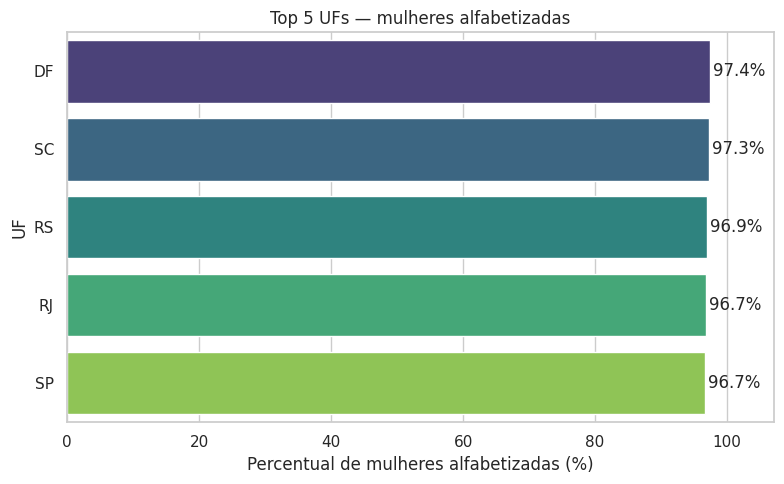

In [ ]:

sns.set(style="whitegrid")

# filtrar apenas alfabetizadas
df_alfa_mul = dist_uf_comparativa[dist_uf_comparativa['alfabetizacao'] == 'Alfabetizadas'].copy()

if df_alfa_mul.empty:
    print("Nenhum registro para alfabetizacao='Alfabetizadas'.")
else:
    # ordenar por percentual_mulheres e pegar top5
    top5 = df_alfa_mul.sort_values('percentual_mulheres', ascending=False).head(5).copy()
    top5['percent'] = top5['percentual_mulheres'] * 100

    # Gráfico horizontal
    plt.figure(figsize=(8,5))
    sns.barplot(
            data=top5,
            x='percent',
            y='sigla_uf',
            hue='sigla_uf',
            palette='viridis',
            legend=False,
            order=top5['sigla_uf'].tolist()
        )
    plt.xlabel('Percentual de mulheres alfabetizadas (%)')
    plt.ylabel('UF')
    plt.title('Top 5 UFs — mulheres alfabetizadas')

    # anotar valores
    for i, v in enumerate(top5['percent'].values):
        plt.text(v + 0.5, i, f"{v:.1f}%", va='center')

    plt.xlim(0, top5['percent'].max() * 1.1)
    plt.tight_layout()
    plt.show()


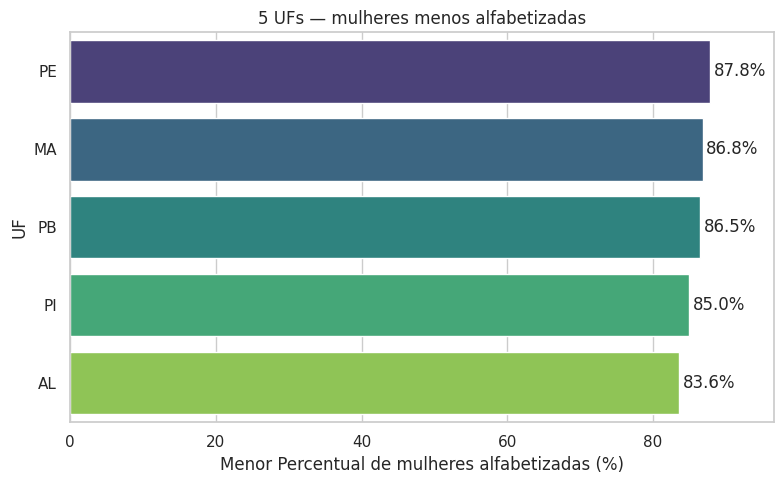

In [ ]:

sns.set(style="whitegrid")

# filtrar apenas alfabetizadas
df_alfa_mul = dist_uf_comparativa[dist_uf_comparativa['alfabetizacao'] == 'Alfabetizadas'].copy()

if df_alfa_mul.empty:
    print("Nenhum registro para alfabetizacao='Alfabetizadas'.")
else:
    # ordenar por percentual_mulheres e pegar tail5
    top5 = df_alfa_mul.sort_values('percentual_mulheres', ascending=False).tail(5).copy()
    top5['percent'] = top5['percentual_mulheres'] * 100

    # Gráfico horizontal
    plt.figure(figsize=(8,5))
    sns.barplot(
            data=top5,
            x='percent',
            y='sigla_uf',
            hue='sigla_uf',
            palette='viridis',
            legend=False,
            order=top5['sigla_uf'].tolist()
        )
    plt.xlabel('Menor Percentual de mulheres alfabetizadas (%)')
    plt.ylabel('UF')
    plt.title('5 UFs — mulheres menos alfabetizadas')

    # anotar valores
    for i, v in enumerate(top5['percent'].values):
        plt.text(v + 0.5, i, f"{v:.1f}%", va='center')

    plt.xlim(0, top5['percent'].max() * 1.1)
    plt.tight_layout()
    plt.show()


In [ ]:
# **Quais capitais concentram os maiores e menores índices de alfabetização entre mulheres?**

In [ ]:
# --- Lista de capitais ---
capitais_uf = [
    {"sigla_uf": "AC", "capital": "Rio Branco"},
    {"sigla_uf": "AL", "capital": "Maceió"},
    {"sigla_uf": "AP", "capital": "Macapá"},
    {"sigla_uf": "AM", "capital": "Manaus"},
    {"sigla_uf": "BA", "capital": "Salvador"},
    {"sigla_uf": "CE", "capital": "Fortaleza"},
    {"sigla_uf": "DF", "capital": "Brasília"},
    {"sigla_uf": "ES", "capital": "Vitória"},
    {"sigla_uf": "GO", "capital": "Goiânia"},
    {"sigla_uf": "MA", "capital": "São Luís"},
    {"sigla_uf": "MT", "capital": "Cuiabá"},
    {"sigla_uf": "MS", "capital": "Campo Grande"},
    {"sigla_uf": "MG", "capital": "Belo Horizonte"},
    {"sigla_uf": "PA", "capital": "Belém"},
    {"sigla_uf": "PB", "capital": "João Pessoa"},
    {"sigla_uf": "PR", "capital": "Curitiba"},
    {"sigla_uf": "PE", "capital": "Recife"},
    {"sigla_uf": "PI", "capital": "Teresina"},
    {"sigla_uf": "RJ", "capital": "Rio de Janeiro"},
    {"sigla_uf": "RN", "capital": "Natal"},
    {"sigla_uf": "RS", "capital": "Porto Alegre"},
    {"sigla_uf": "RO", "capital": "Porto Velho"},
    {"sigla_uf": "RR", "capital": "Boa Vista"},
    {"sigla_uf": "SC", "capital": "Florianópolis"},
    {"sigla_uf": "SP", "capital": "São Paulo"},
    {"sigla_uf": "SE", "capital": "Aracaju"},
    {"sigla_uf": "TO", "capital": "Palmas"}
]

df_capitais = pd.DataFrame(capitais_uf)

# --- Filtrar apenas alfabetizados ---
df_alfa = dist_uf_comparativa[dist_uf_comparativa["alfabetizacao"] == "Alfabetizadas"].copy()

# --- Juntar capital ↔ UF ---
df_alfa = df_alfa.merge(df_capitais, on="sigla_uf", how="left")

# Calcular coluna de diferença percentual 
df_alfa["dif_percentual"] = df_alfa["percentual_mulheres"] - df_alfa["percentual_homens"]

# --- TOP 5 capitais onde mulheres têm maior vantagem ---
top5 = df_alfa.sort_values("dif_percentual", ascending=False).head(5)

# --- BOTTOM 5 capitais onde a vantagem é menor ou negativa ---
bottom5 = df_alfa.sort_values("dif_percentual", ascending=True).head(5)

print("\n Top 5 capitais com MAIOR diferença de alfabetização favorável às mulheres:\n")
print(top5[["sigla_uf", "capital", "percentual_mulheres", "percentual_homens", "dif_percentual"]])

print("\n Top 5 capitais com MENOR diferença (ou diferença negativa):\n")
print(bottom5[["sigla_uf", "capital", "percentual_mulheres", "percentual_homens", "dif_percentual"]])



 Top 5 capitais com MAIOR diferença de alfabetização favorável às mulheres:


 Top 5 capitais com MENOR diferença (ou diferença negativa):

   sigla_uf        capital  percentual_mulheres  percentual_homens  \
17       PR       Curitiba             0.952994           0.961166   
25       SP      São Paulo             0.966954           0.971030   
7        ES        Vitória             0.942810           0.944820   
11       MS   Campo Grande             0.945327           0.946946   
23       SC  Florianópolis             0.972797           0.973829   

    dif_percentual  
17       -0.008172  
25       -0.004076  
7        -0.002010  
11       -0.001619  
23       -0.001032  


# **Como é distribuída a população feminina alfabetizada por dentro das regiões brasileiras?**

In [18]:
# Adicionar região
uf_to_region = {
    'AC': 'Norte', 'AL': 'Nordeste', 'AP': 'Norte', 'AM': 'Norte', 'BA': 'Nordeste',
    'CE': 'Nordeste', 'DF': 'Centro-Oeste', 'ES': 'Sudeste', 'GO': 'Centro-Oeste',
    'MA': 'Nordeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste', 'MG': 'Sudeste',
    'PA': 'Norte', 'PB': 'Nordeste', 'PR': 'Sul', 'PE': 'Nordeste', 'PI': 'Nordeste',
    'RJ': 'Sudeste', 'RN': 'Nordeste', 'RS': 'Sul', 'RO': 'Norte', 'RR': 'Norte',
    'SC': 'Sul', 'SP': 'Sudeste', 'SE': 'Nordeste', 'TO': 'Norte'
}

df_censo['region'] = df_censo['sigla_uf'].map(uf_to_region).fillna('Desconhecida')

# filtrar apenas mulheres
df_mulheres = df_censo[df_censo['sexo'] == 'Mulheres'].copy()

# garantir tipo numérico
df_mulheres['populacao'] = (
    pd.to_numeric(df_mulheres['populacao'], errors='coerce')
    .fillna(0)
)

In [19]:
# Agregar alfabetização feminina por UF
df_uf = (
    df_mulheres
    .groupby(['region', 'sigla_uf', 'alfabetizacao'])['populacao']
    .sum()
    .reset_index()
)

In [20]:
# Total de mulheres por UF e região
totais_uf = (
    df_mulheres
    .groupby(['region','sigla_uf'])['populacao']
    .sum()
    .rename('total_mulheres')
    .reset_index()
)

In [21]:
# Juntar e calcular percentuais
df_uf = df_uf.merge(totais_uf, on=['region','sigla_uf'], how='left')

df_uf['percentual'] = df_uf['populacao'] / df_uf['total_mulheres']

df_uf.head(10)

,region,sigla_uf,alfabetizacao,populacao,total_mulheres,percentual
0,Centro-Oeste,DF,Alfabetizadas,1180404,1212089,0.973859
1,Centro-Oeste,DF,Não alfabetizadas,31685,1212089,0.026141
2,Centro-Oeste,GO,Alfabetizadas,2739574,2887665,0.948716
3,Centro-Oeste,GO,Não alfabetizadas,148091,2887665,0.051284
4,Centro-Oeste,MS,Alfabetizadas,1042384,1102670,0.945327
5,Centro-Oeste,MS,Não alfabetizadas,60286,1102670,0.054673
6,Centro-Oeste,MT,Alfabetizadas,1332752,1410654,0.944776
7,Centro-Oeste,MT,Não alfabetizadas,77902,1410654,0.055224
8,Nordeste,AL,Alfabetizadas,1071264,1280928,0.836319
9,Nordeste,AL,Não alfabetizadas,209664,1280928,0.163681


In [24]:
# Filtrar somente mulheres alfabetizadas por UF 
df_mulheres = df_censo[df_censo['sexo'] == 'Mulheres'].copy()
df_mulheres['populacao'] = pd.to_numeric(df_mulheres['populacao'], errors='coerce').fillna(0)

df_alfa = (
    df_mulheres[df_mulheres['alfabetizacao'] == 'Alfabetizadas']
    .groupby(['region', 'sigla_uf'], as_index=False)['populacao']
    .sum()
    .rename(columns={'populacao': 'populacao_alfabetizadas'})
)

# Totais por região (para percentuais)
region_totals = df_alfa.groupby('region', as_index=False)['populacao_alfabetizadas'].sum().rename(columns={'populacao_alfabetizadas':'region_total'})
df_alfa = df_alfa.merge(region_totals, on='region', how='left')
df_alfa['pct_da_regiao'] = df_alfa['populacao_alfabetizadas'] / df_alfa['region_total']

# Coluna formatada para hover
df_alfa['hover_pct'] = (df_alfa['pct_da_regiao'] * 100).round(2).astype(str) + '%'

# Plot
fig = px.treemap(
    df_alfa,
    path=['region', 'sigla_uf'],
    values='populacao_alfabetizadas',
    color='region',                     # cores por região
    hover_data={'populacao_alfabetizadas': True, 'hover_pct': True, 'region_total': False, 'region': False}
)
fig.update_traces(textinfo='label+value+percent parent')  # mostra label, valor e % relativo ao pai
fig.update_layout(title='Treemap — Mulheres alfabetizadas por Região e UF')
fig.show()

### **CAPÍTULO 2 — Desigualdades raciais entre mulheres alfabetizadas**

Perguntas selecionadas:

8. **Em quais regiões a desigualdade racial entre mulheres alfabetizadas é mais intensa?**
9. **Existe uma “correlação regional” entre proporção racial de mulheres e menor alfabetização feminina?**

**Objetivo:**
Mostrar que desigualdade racial não é homogênea — é territorial.
Aqui entram correlações, heatmaps, clusters.

In [30]:
# Funções utilitárias (Gini ponderado)
def weighted_gini(values, weights):
    """
    O Gini é usado para medir desigualdade de renda, mas serve igualmente para desigualdade de taxas 
    de alfabetização entre grupos raciais.
    
    Gini coefficient weighted.
    values: array-like of values (ex: taxas por grupo)
    weights: array-like of weights (ex: população feminina do grupo)
    """

def weighted_gini(values, weights):
    v = np.array(values, dtype=float)
    w = np.array(weights, dtype=float)

    mask = (w > 0) & (~np.isnan(v))
    v = v[mask]
    w = w[mask]

    if len(v) == 0:
        return np.nan

    order = np.argsort(v)
    v = v[order]
    w = w[order]

    cumw = np.cumsum(w)
    cumv = np.cumsum(v * w)

    sumw = cumw[-1]
    sumvw = cumv[-1]

    if sumw == 0 or sumvw == 0:
        return np.nan

    relcumw = cumw / sumw
    relcumv = cumv / sumvw

    B = np.sum(relcumv[:-1] * (relcumw[1:] - relcumw[:-1]))
    G = 1 - 2 * B

    return float(G)

In [32]:
# Criar df_bq 
df_base = df_censo.copy()

# garantir formato
df_base['populacao'] = pd.to_numeric(df_base['populacao'], errors='coerce').fillna(0)

# MULHERES alfabetizadas por UF x raça
df_mulheres_alf = (
    df_base[
        (df_base['sexo'] == 'Mulheres') &
        (df_base['alfabetizacao'] == 'Alfabetizadas')
    ]
    .groupby(['sigla_uf', 'cor_raca'], as_index=False)['populacao']
    .sum()
    .rename(columns={'populacao': 'populacao_mulheres'})
)

# TOTAL de MULHERES por UF x raça
df_mulheres_total = (
    df_base[df_base['sexo'] == 'Mulheres']
    .groupby(['sigla_uf', 'cor_raca'], as_index=False)['populacao']
    .sum()
    .rename(columns={'populacao': 'populacao_total'})
)

# JUNTAR → formar df_bq
df_bq = df_mulheres_total.merge(
    df_mulheres_alf,
    on=['sigla_uf', 'cor_raca'],
    how='left'
)

df_bq['populacao_mulheres'] = df_bq['populacao_mulheres'].fillna(0).astype(int)
df_bq['populacao_total'] = df_bq['populacao_total'].astype(int)

# taxa (opcional, seu código recalcula depois)
df_bq['taxa_alf_fem'] = df_bq['populacao_mulheres'] / df_bq['populacao_total'].replace({0: np.nan})

df_bq.head()


,sigla_uf,cor_raca,populacao_total,populacao_mulheres,taxa_alf_fem
0,AC,Amarela,892,814,0.912556
1,AC,Branca,65765,60307,0.917008
2,AC,Indígena,7798,5478,0.702488
3,AC,Parda,206223,184096,0.892704
4,AC,Preta,25983,21924,0.843782


In [ ]:
# ------------------------------------------------------------
# DESIGUALDADE RACIAL ENTRE MULHERES ALFABETIZADAS POR REGIÃO
# ------------------------------------------------------------

df_bq['region'] = df_bq['sigla_uf'].map(uf_to_region)

# -------------------------------------------------------------------
# Taxa de alfabetização feminina por raça (df_bq já possui valores)
# -------------------------------------------------------------------
# Fórmula:
# taxa_alf_fem = populacao_mulheres / populacao_total

df_bq['taxa_alf_fem'] = (
    df_bq['populacao_mulheres'] /
    df_bq['populacao_total'].replace({0: np.nan})
)

# ---------------------------------------------------
# Agregação por REGIÃO x RAÇA com pesos populacionais
# ---------------------------------------------------
grp = (
    df_bq
    .groupby(['region', 'cor_raca'], as_index=False)
    .agg({
        'populacao_mulheres': 'sum',
        'populacao_total': 'sum'
    })
)

grp['taxa_alf_fem_raca'] = (
    grp['populacao_mulheres'] /
    grp['populacao_total'].replace({0: np.nan})
)

# -------------------------------------------------------
# Cálculo das métricas de desigualdade racial por região
# -------------------------------------------------------
results = []

for region, g in grp.groupby('region'):
    taxas = g['taxa_alf_fem_raca'].values
    pesos = g['populacao_total'].values  # usar população total como peso

    rng = np.nanmax(taxas) - np.nanmin(taxas)
    std = np.nanstd(taxas)
    mean = np.nanmean(taxas)
    cv = std / mean if mean > 0 else np.nan
    gini = weighted_gini(taxas, pesos)

    results.append({
        'region': region,
        'range': rng,
        'std': std,
        'mean': mean,
        'cv': cv,
        'gini_weighted': gini,
        'num_racas': len(g)
    })

df_desigualdade = pd.DataFrame(results).sort_values('gini_weighted', ascending=False)

display(df_desigualdade)



,region,range,std,mean,cv,gini_weighted,num_racas
4,Sul,0.110629,0.038682,0.941157,0.041101,0.602471,5
2,Norte,0.161212,0.058120,0.904825,0.064233,0.517445,5
1,Nordeste,0.075766,0.029096,0.865993,0.033598,0.447383,5
0,Centro-Oeste,0.137719,0.048831,0.931357,0.052430,0.426971,5
3,Sudeste,0.070156,0.024489,0.951840,0.025728,0.420958,5


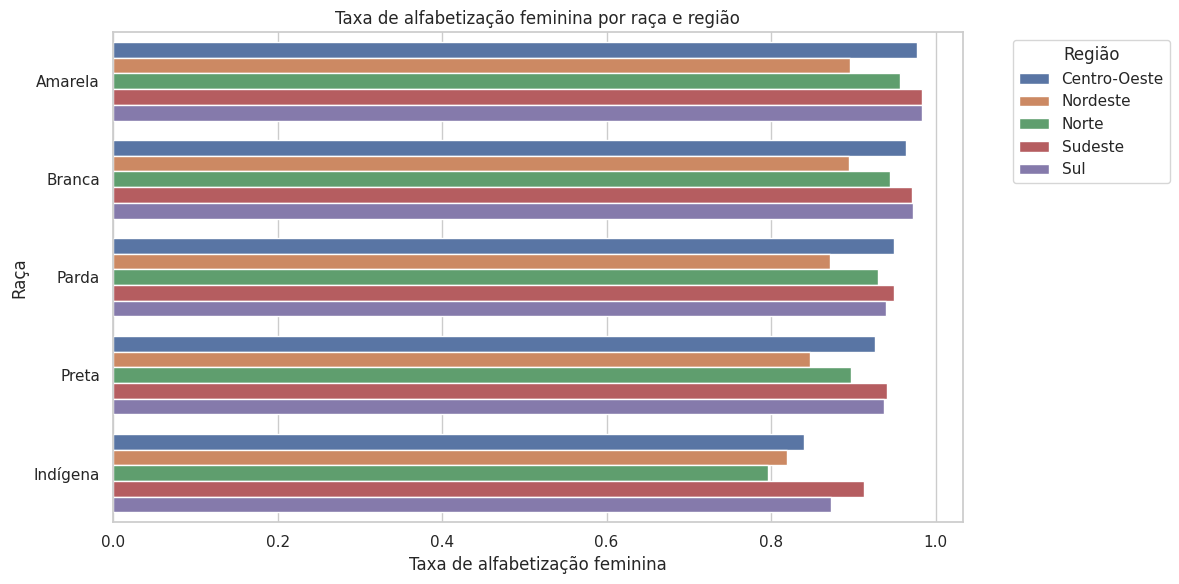

In [34]:
# -------------------------------------
# Visualização: taxa por raça/região
# -------------------------------------
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

plt.figure(figsize=(12,6))
sns.barplot(
    data=grp.sort_values(['region','taxa_alf_fem_raca'], ascending=[True, False]),
    x='taxa_alf_fem_raca',
    y='cor_raca',
    hue='region'
)
plt.title("Taxa de alfabetização feminina por raça e região")
plt.xlabel("Taxa de alfabetização feminina")
plt.ylabel("Raça")
plt.legend(title="Região", bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

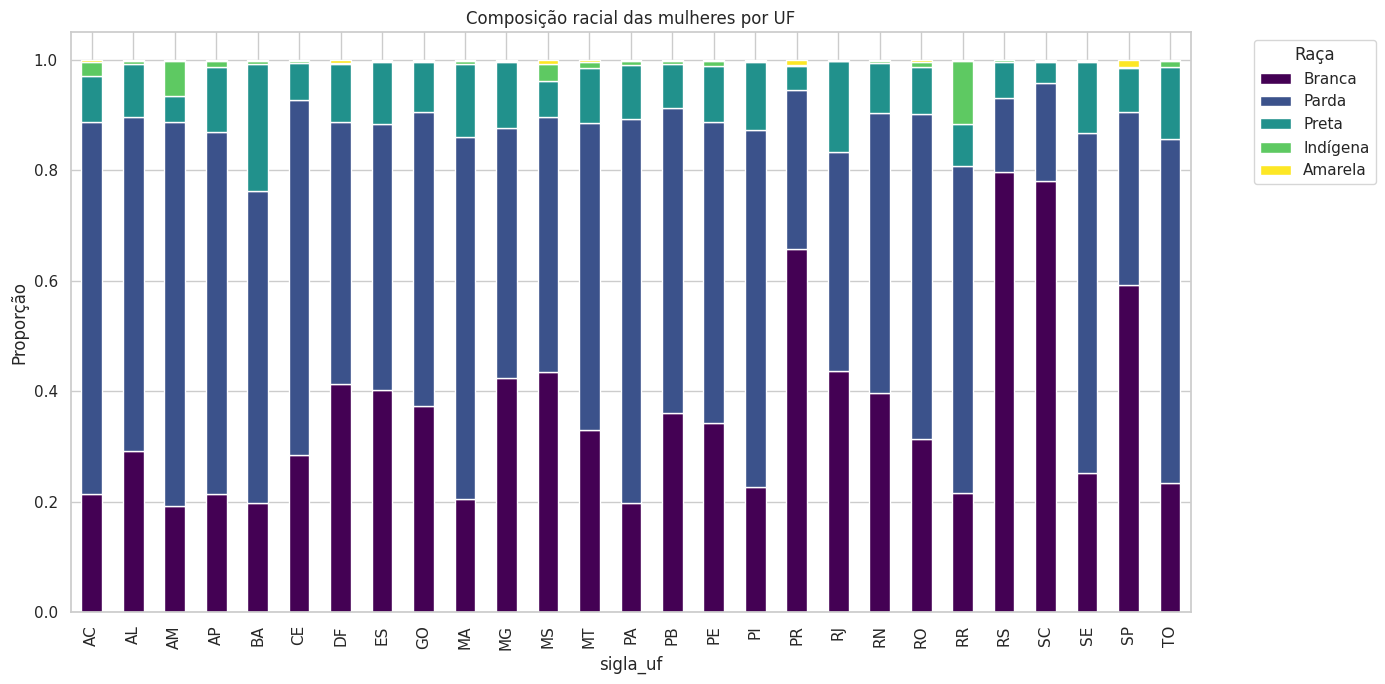

In [40]:
pivot2 = pivot.copy()
pivot2 = pivot2.loc[:, ['Branca','Parda','Preta','Indígena','Amarela']]

pivot2.plot(kind='bar', stacked=True, figsize=(14,7), colormap='viridis')
plt.title("Composição racial das mulheres por UF")
plt.ylabel("Proporção")
plt.legend(title="Raça", bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


###  **CAPÍTULO 3 — Acesso à educação por raça (microdados da educação básica)**

Perguntas selecionadas:

. **A diferença de matrícula por raça é maior nos anos iniciais, finais do fundamental ou no ensino médio?**
. **Existe diferença racial na trajetória educacional feminina ao longo dos níveis?**

**Objetivo:**
Mostrar que a desigualdade *começa antes* da alfabetização.
Explicar caminhos educacionais desiguais.

#  **A diferença de matrícula por raça é maior nos anos iniciais, finais do fundamental ou no ensino médio?**

In [51]:
# dicionário de raças (mesma sua)
raca_map = {
    'Branca': 'QT_MAT_BAS_BRANCA',
    'Preta': 'QT_MAT_BAS_PRETA',
    'Parda': 'QT_MAT_BAS_PARDA',
    'Amarela': 'QT_MAT_BAS_AMARELA',
    'Indígena': 'QT_MAT_BAS_INDIGENA'
}

# níveis já definidos (nome -> coluna com total de matrículas no nível)
niveis = {
    'Infantil': 'mat_inf',
    'Fund_AI': 'mat_fund_ai',
    'Fund_AF': 'mat_fund_af',
    'Medio': 'mat_med'
}

# 1) Construir tabela agregada: matrículas estimadas por nível x raça (somatório por todo o dataframe)
# Se você já criou colunas como 'Infantil_Branca' via pct * total, pule essa etapa e use-as diretamente.
est = {}
for nivel, col_nivel in niveis.items():
    # somar por raça: usar a distribuição racial (pct_<raca>) se existirem, senão aplicar fallback via proporção direta
    row = {}
    for raca in raca_map.keys():
        col_est = f"{nivel}_{raca}"
        if col_est in df.columns:
            valor = df[col_est].sum()
        else:
            # fallback: aplicar proporção racial do baseline (pct_<raca>) ao total do nível
            pct_col = f"pct_{raca}"
            if pct_col in df.columns:
                valor = (df[col_nivel] * df[pct_col]).sum()
            else:
                # último recurso: usar a coluna de matrículas básicas por raça proporcionalmente
                base_col = raca_map[raca]
                total_base = df[base_col].sum()
                total_bas = df[list(raca_map.values())].sum(axis=1).sum()
                prop = (total_base / total_bas) if total_bas > 0 else 0
                valor = df[col_nivel].sum() * prop
        row[raca] = valor
    est[nivel] = row

# 2) transformar em DataFrame (níveis x raças)
df_niveis_raca = pd.DataFrame.from_dict(est, orient='index').fillna(0)
df_niveis_raca.index.name = 'nivel'
# ex: df_niveis_raca.loc['Infantil','Branca'] -> matrículas estimadas de Brancas na Infantil

# 3) calcular métricas de desigualdade por nível
results = []
for nivel in df_niveis_raca.index:
    vals = df_niveis_raca.loc[nivel].values.astype(float)
    maior = vals.max()
    menor = vals.min()
    range_abs = maior - menor
    razao = maior / menor if menor > 0 else np.nan
    mean = vals.mean() if len(vals)>0 else np.nan
    range_rel = range_abs / mean if (mean and mean>0) else np.nan

    # Gini opcional (se weighted_gini estiver definido)
    try:
        # usar pesos iguais (ou usar valores das populações se você tiver)
        gini = weighted_gini(vals, np.ones_like(vals))
    except Exception:
        gini = np.nan

    results.append({
        'nivel': nivel,
        'maior_matricula_racial': maior,
        'menor_matricula_racial': menor,
        'desigualdade_range_abs': range_abs,
        'desigualdade_razao': razao,
        'desigualdade_range_rel': range_rel,
        'gini': gini
    })

df_desigualdade_niveis = pd.DataFrame(results).set_index('nivel').sort_values('desigualdade_range_abs', ascending=False)

# Converter matrículas absolutas para proporção dentro do nível
df_niveis_raca_pct = df_niveis_raca.div(df_niveis_raca.sum(axis=1), axis=0) * 100
df_niveis_raca_pct = df_niveis_raca_pct.round(2)

print("Matriz em % (níveis x raças):")
display(df_niveis_raca_pct)

# exibir matriz e resultados
print("Matriz (níveis x raças):")
display(df_niveis_raca)

print("\nDesigualdade por nível:")
display(df_desigualdade_niveis)


Matriz em % (níveis x raças):


,Branca,Preta,Parda,Amarela,Indígena
nivel,,,,,
Infantil,47.00,4.45,47.20,0.47,0.89
Fund_AI,43.48,4.38,50.63,0.45,1.07
Fund_AF,42.07,4.45,52.07,0.45,0.95
Medio,42.66,5.21,50.86,0.53,0.73


Matriz (níveis x raças):


,Branca,Preta,Parda,Amarela,Indígena
nivel,,,,,
Infantil,8.431350e+06,798028.989545,8.467425e+06,84434.717001,159620.588734
Fund_AI,6.312464e+06,636453.269382,7.350651e+06,64782.572062,155163.295492
Fund_AF,5.001334e+06,528894.173405,6.190825e+06,53907.941118,113413.133378
Medio,3.355424e+06,410020.407579,3.999649e+06,41854.883604,57700.218633



Desigualdade por nível:


,maior_matricula_racial,menor_matricula_racial,desigualdade_range_abs,desigualdade_razao,desigualdade_range_rel,gini
nivel,,,,,,
Infantil,8.467425e+06,84434.717001,8.382991e+06,100.283695,2.336285,0.758228
Fund_AI,7.350651e+06,64782.572062,7.285869e+06,113.466490,2.508992,0.771067
Fund_AF,6.190825e+06,53907.941118,6.136917e+06,114.840689,2.581058,0.777430
Medio,3.999649e+06,41854.883604,3.957794e+06,95.559908,2.516193,0.770315


### **CAPÍTULO 4 — Contrastes regionais extremos (Norte vs Sul)**

Perguntas selecionadas:

16. **Quais as taxas de alfabetização no Norte e Nordeste entre mulheres?**
17. **Quais as taxas de alfabetização nas capitais do Sul e Sudeste?**
18. **Existe um “mapa de desigualdade feminina” claro no Brasil?**
19. **Os municípios com maior diversidade racial feminina apresentam maior desigualdade de alfabetização?**

**Objetivo:**
Construir um argumento visual de desigualdade territorial.
Usar mapas e comparações diretas.